# Encoding data into state coefficients (analogue encoding)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #avoids conda Intel openmp polluting the matplotlib libraries

In [2]:
# Use nonlinear least squares to determine the coefficients of the states to encode the numerical vector data.
# Given the 2*num_qubits coefficients needed for each individual qubit, we solve f(x)=b, wherein the b is the 
# data to be encoded, x are the qubit coefficients, where a 1d array of length N holds N/2 qubits, with the 
#|0> and |1> states in alternating odd/even patterns, and f(x) is the kronecker producted coefficients of 
# these individual qubit pure states.
import numpy as np
import scipy.optimize
import cProfile as Profile

num_qubits = 8

#Function that computes the kronecker product of each individual qubit, and returns an array with each state coeff
def func(x):
    qubits = []
    for ii in range(0,len(x),2):
        qubits.append(np.array([x[ii],x[ii+1]]))
    coeffs = [1]
    for ii in range(0,len(x)//2):
        coeffs = np.kron(coeffs, qubits[ii])
    return np.array(coeffs)

#f(x) - b = 0 to be solved
def nl_eqs(x, *rhs):
    res = func(x)-rhs/np.linalg.norm(rhs)
    return res

#Vector data to encode
data_vals = [3.42, 1.24, 1.97, 0.72]*(2**(num_qubits-2)) #np.ones(2**num_qubits)

#Initial values for the qubits. 
qubit_init_coeff = 1/(np.sqrt(2))*np.ones(2*num_qubits)

#Constrained NL LSQ, with coefficients between -1 and 1.
x = scipy.optimize.least_squares(nl_eqs, qubit_init_coeff, bounds=([-1,1]), args=data_vals, tr_solver='lsmr').x
#Profile.run("x = scipy.optimize.least_squares(nl_eqs, qubit_init_coeff, bounds=([-1,1]), args=data_vals, tr_solver='lsmr').x")
#Profile.run("x = scipy.optimize.least_squares(nl_eqs, qubit_init_coeff, args=data_vals, method='lm').x")
for ii in range(0,len(x),2):
    x[ii:ii+2] = x[ii:ii+2]/np.linalg.norm(x[ii:ii+2])
print(x)

[0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
 0.86632121 0.4994873  0.93989541 0.34146247]


Following the work of PRL 114 110504 (2015) we can achieve similar state coeffs by using the given data state. We can wrap the above method up into a function as follows.

In [3]:
def encoding_data(data_vec):
    #Ensure we have enough qubits to encode string, and pad if data is non power of 2
    dvec = np.array(data_vec)
    lg2_len = np.log2(len(dvec))
    required_qubits = np.ceil(lg2_len)
    num_qubits = int(required_qubits)
    if lg2_len != required_qubits:
        dz = np.zeros(2**num_qubits)
        dz[:dvec.shape[0]] = dvec
        dvec = dz

    #Assign initial values
    qubit_init_coeff = 1/(np.sqrt(2))*np.ones(2*num_qubits)
    #Perform NLLSQ
    x =  scipy.optimize.least_squares(nl_eqs, qubit_init_coeff, bounds=([-1,1]), args=dvec).x
    
    #Ensure the resulting states are normalised according to each qubit's coefficients
    for ii in range(0,len(x),2):
        x[ii:ii+2] = x[ii:ii+2]/np.linalg.norm(x[ii:ii+2])
    return x
    

In [4]:
y = encoding_data([0.5,0.5,0.9,0.1]*64)
y

array([0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.58959226, 0.80770104, 0.93859678,
       0.34501606])

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, QuantumCircuit, execute, Aer, IBMQ, compile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

u_backend = BasicAer.get_backend('unitary_simulator')
num_samples = 30000

Examine the encoding of data into a single qubit first. Extract the unitary evolution matrix corresponding with a $R_y(2\theta)$ rotation to place the qubit into the appropriate state


In [6]:
q = QuantumRegister(1)            
rot_circ = QuantumCircuit(q)
rot_circ.ry(2*np.arccos(x[ii]), q[0])

job = execute(rot_circ, u_backend)
u_mat = job.result().get_unitary(rot_circ, decimals=3)
print("U matrix:= ")
print (u_mat)
print("Applying matrix to state |0> = [1,0]^T")
print (np.matmul(u_mat, [1, 0]))

U matrix:= 
[[ 0.94 +0.j -0.341+0.j]
 [ 0.341+0.j  0.94 +0.j]]
Applying matrix to state |0> = [1,0]^T
[0.94 +0.j 0.341+0.j]


Now that we have a method to encode data into a single qubit, we can encode the full vector data into the entire register as follows. We begin by defining the starting location of the GHZ state we wish to encode data into. For that, we need to examine the control qubit (0) and apply a controlled $R_y$ operation if it is set, to ensure the test data is set into state $|00\ldots\rangle$ and the reference data in state $|11\ldots\rangle$.

In [7]:
# In memory DB for storing values
import sqlite3
if 'conn' in globals():
    conn.close()
conn = sqlite3.connect(':memory:')
# Get a cursor object
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE q_states(id INTEGER PRIMARY KEY, state_key TEXT,
                       dtheta REAL, counts INTEGER, num_qubits INTEGER, measured_reg TEXT)
''')

In the next step, we compare two vectors, wherein one of the two is rotated through an angle, $\Delta \theta$, from $0$ to $2\pi$. The resulting counts are recorded into the previously created database, with the correspodning angle and state label.

In the previously coded examples, the measurement was required on the full set of qubits to examine the outcome. However, by applying another H gate to the auxiliary qubit, we can modify the phase given by the encoded states. Taking an estimate of the population as the counts in $\vert 0\rangle$ auxiliary state over the total number of samples gives an approx. for the dot product, as seen by the comparison with the numpy `dot(x,y)` function below the next cell.

In [8]:
q = QuantumRegister(num_qubits); #Entangled state for storing vectors
a = QuantumRegister(1); #Ancililary qubit for measurements
c_a = ClassicalRegister(1); #Classical measurement from auxiliary qubit
c_q = ClassicalRegister(num_qubits); #C measurement on rest of qubit

ghz_circ = QuantumCircuit(a, q, c_a, c_q);
ghz_circ.h(a[0]);           

for ii in range(0,len(x),2):
    ghz_circ.cu3(2*np.arccos(x[ii]), 0, 0, a[0], q[ii//2])

#Next, encode the reference data by flipping the first bit to allow it into the |11> state
ghz_circ.x(a[0])
for ii in range(0,len(y),2):
    ghz_circ.cu3(2*np.arccos(y[ii]), 0, 0, a[0], q[ii//2])

#Encode the information into the phase of the auxiliary qubit
ghz_circ.h(a[0])

ghz_circ.measure(a, c_a)
backend = Aer.get_backend('qasm_simulator')
qobj = compile(ghz_circ, backend, shots=num_samples)
job = backend.run(qobj)
result = job.result()
counts = result.get_counts()
print(counts)

{'00000000 1': 1332, '00000000 0': 28668}


In [9]:
((np.dot(x,y)/num_qubits) / (counts['00000000 0']/num_samples))

1.0352403635548026

In [10]:
import qiskit.tools.visualization as vv
import matplotlib

/Users/mlxd/workspace/quantum/intel-qnlp/corpus/install/intel-qnlp_conda/envs/intel-qnlp/lib/python3.7/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)


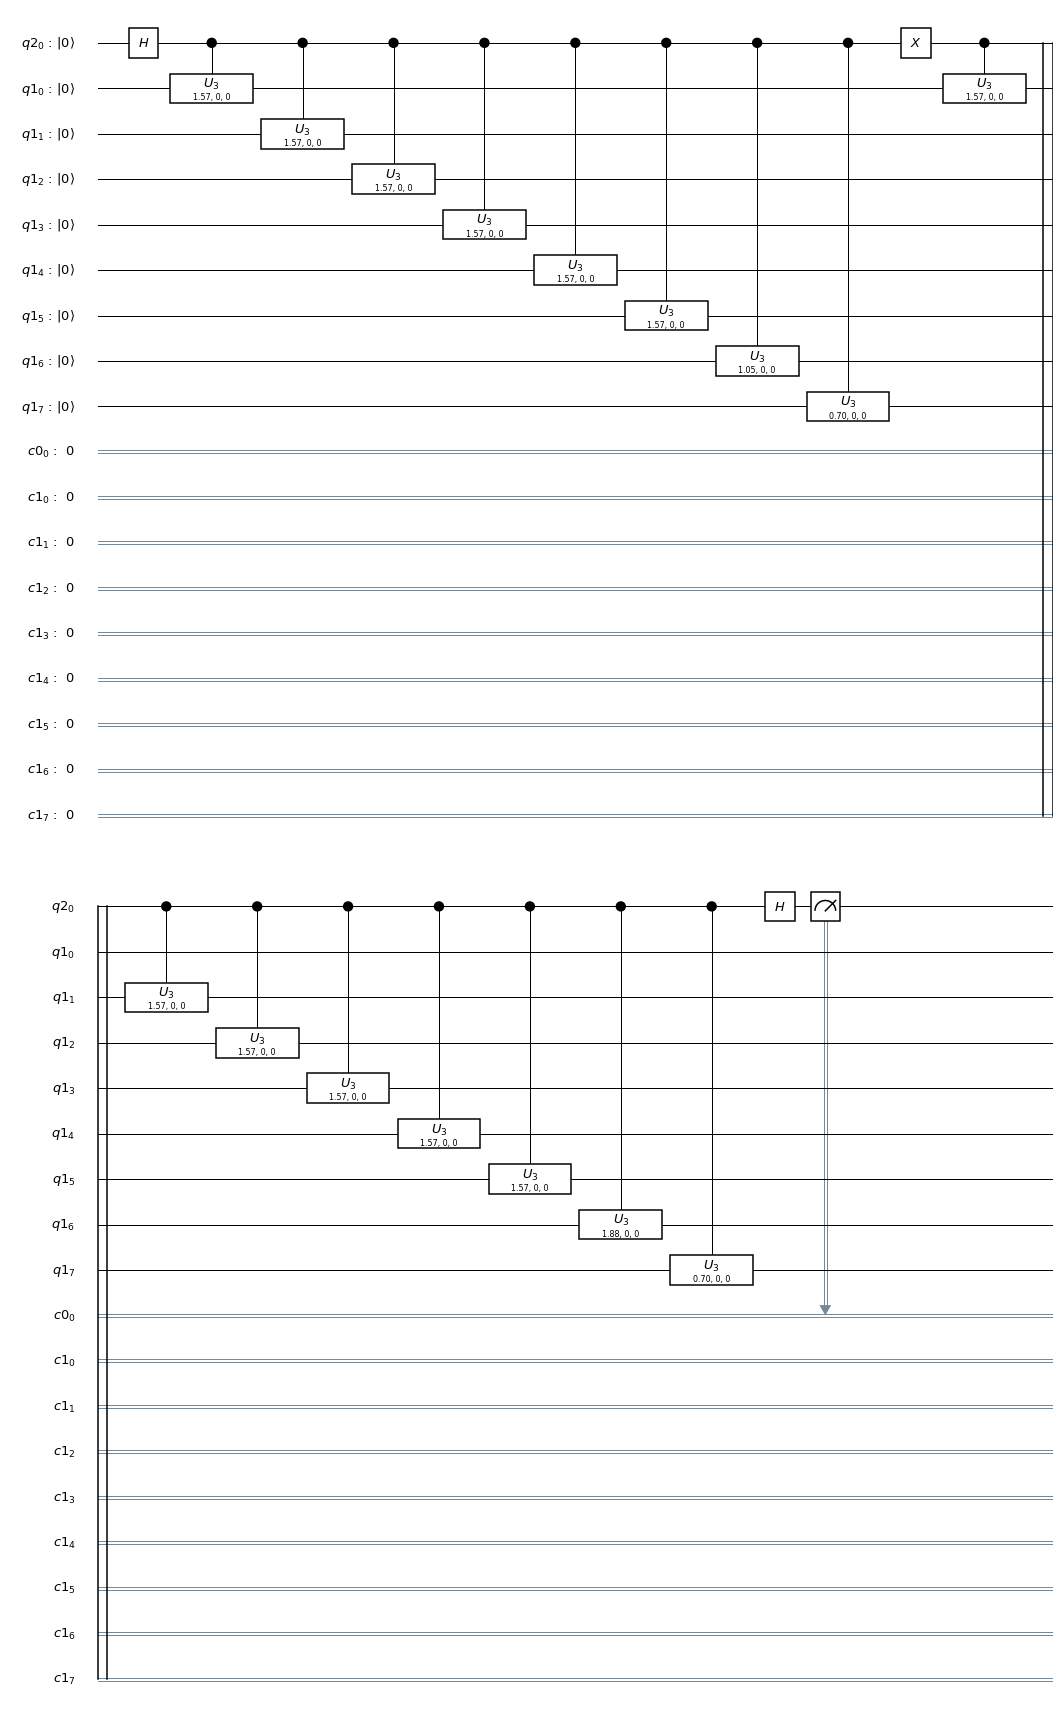

In [11]:
vv.circuit_drawer(ghz_circ)

In [12]:
num_qubits = 6
for th in np.linspace(0, 2*np.pi, 100, endpoint=True):
    #Prepare the GHZ state on qubits 1,2, and use 0 as the control qubit for Rotations
    q = QuantumRegister(num_qubits); #Entangled state for storing vectors
    a = QuantumRegister(1); #Ancililary qubit for measurements
    c_a = ClassicalRegister(1); #Classical measurement from auxiliary qubit
    c_q = ClassicalRegister(num_qubits); #C measurement on rest of qubit

    ghz_circ = QuantumCircuit(a, q, c_a, c_q);
    
    ghz_circ.h(a[0]);

    #Encode the data to test
    x = [1,0]*num_qubits
    y = [np.cos(th),np.sin(th)]*num_qubits
    for ii in range(0,len(x),2):
        ghz_circ.cu3(2*np.arccos(x[ii]), 0, 0, a[0], q[ii//2])
        #ghz_circ.crz(2*np.arccos(x[ii]), a[0], q[ii//2])

    #Next, encode the reference data by flipping the first bit to allow it into the |11> state
    ghz_circ.x(a[0])
    for ii in range(0,len(y),2):
        ghz_circ.cu3(2*np.arccos(y[ii]), 0, 0, a[0], q[ii//2])
        #ghz_circ.crz(2*np.arccos(x[ii]), a[0], q[ii//2])

    #Encode the information into the phase of the auxiliary qubit        
    ghz_circ.h(a[0])

    #Extract result from auxiliary qubit measurement
    m_aux = 1
    m_q = 0
    if m_aux:
        ghz_circ.measure(a, c_a)
        backend = Aer.get_backend('qasm_simulator')
        qobj = compile(ghz_circ, backend, shots=num_samples)
        job = backend.run(qobj)
        result = job.result()
        counts = result.get_counts()
        print(counts)
        for k,v in counts.items():
            cursor.execute('''INSERT INTO q_states(state_key, dtheta, counts, num_qubits, measured_reg) 
                            VALUES(?,?,?,?,?)''', (k, th, v, num_qubits, 'a'))

    if m_q:
        ghz_circ.measure(q, c_q)
        backend = Aer.get_backend('qasm_simulator')
        qobj = compile(ghz_circ, backend, shots=num_samples)
        job = backend.run(qobj)
        result = job.result()
        counts = result.get_counts()
        print(counts)
        for k,v in counts.items():
            cursor.execute('''INSERT INTO q_states(state_key, dtheta, counts, num_qubits, measured_reg) 
                            VALUES(?,?,?,?,?)''', (k, th, v, num_qubits, 'q'))

    conn.commit()

{'000000 0': 30000}
{'000000 1': 161, '000000 0': 29839}
{'000000 1': 739, '000000 0': 29261}
{'000000 1': 1513, '000000 0': 28487}
{'000000 1': 2713, '000000 0': 27287}
{'000000 1': 4032, '000000 0': 25968}
{'000000 1': 5451, '000000 0': 24549}
{'000000 1': 6975, '000000 0': 23025}
{'000000 1': 8249, '000000 0': 21751}
{'000000 1': 9612, '000000 0': 20388}
{'000000 1': 10917, '000000 0': 19083}
{'000000 1': 12018, '000000 0': 17982}
{'000000 1': 12745, '000000 0': 17255}
{'000000 1': 13512, '000000 0': 16488}
{'000000 1': 14099, '000000 0': 15901}
{'000000 1': 14500, '000000 0': 15500}
{'000000 1': 14796, '000000 0': 15204}
{'000000 1': 14908, '000000 0': 15092}
{'000000 1': 15055, '000000 0': 14945}
{'000000 1': 14909, '000000 0': 15091}
{'000000 1': 14930, '000000 0': 15070}
{'000000 1': 14901, '000000 0': 15099}
{'000000 1': 14939, '000000 0': 15061}
{'000000 1': 14876, '000000 0': 15124}
{'000000 1': 15074, '000000 0': 14926}
{'000000 1': 15046, '000000 0': 14954}
{'000000 1': 150

In [13]:
ghz_circ.draw()

In [14]:
#Extract the unique state labels and angles for plotting
cursor.execute('''SELECT DISTINCT state_key FROM q_states ''')
uniq_states = [s[0] for s in cursor.fetchall()]
cursor.execute('''SELECT DISTINCT dtheta FROM q_states ''')
angles = [s[0] for s in cursor.fetchall()]

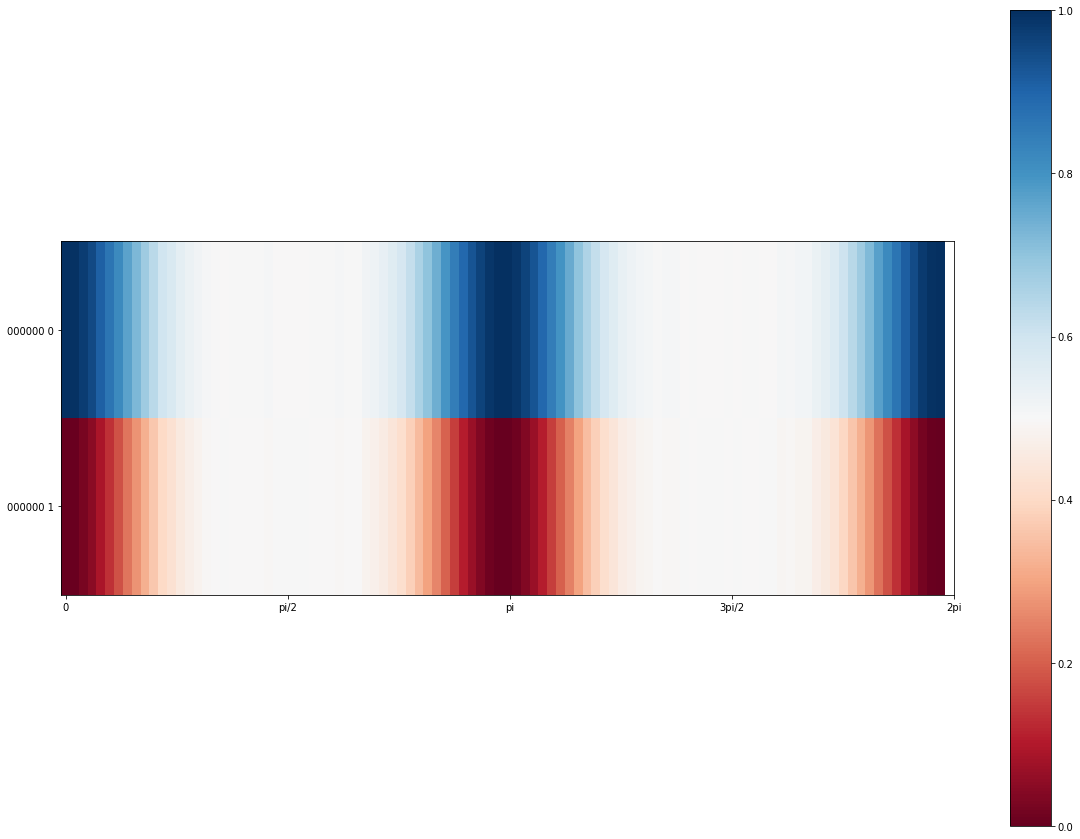

In [15]:
#Extract the appropriate data from the DB and plot the results
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

counts_arr = np.zeros((len(uniq_states), len(angles)));
for c_jj, v_jj in enumerate(uniq_states):
    for c_ii, v_ii in enumerate(angles):
        cursor.execute('''SELECT counts, state_key, dtheta FROM q_states WHERE dtheta=? AND state_key=?''', (v_ii, v_jj,) )
        all_rows = cursor.fetchall()
        for row in all_rows:
            counts_arr[c_jj][c_ii] = row[0];
            
plt.rcParams['figure.figsize'] = [20, 15]
fig, ax = plt.subplots()
im = ax.imshow(counts_arr/num_samples, cmap='RdBu')
ax.set_aspect(20)
plt.xticks([i*16 for i in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]], ['0', 'pi/2', 'pi', '3pi/2', '2pi'])
plt.yticks(np.arange(len(uniq_states)), uniq_states)
cbar = ax.figure.colorbar(im)

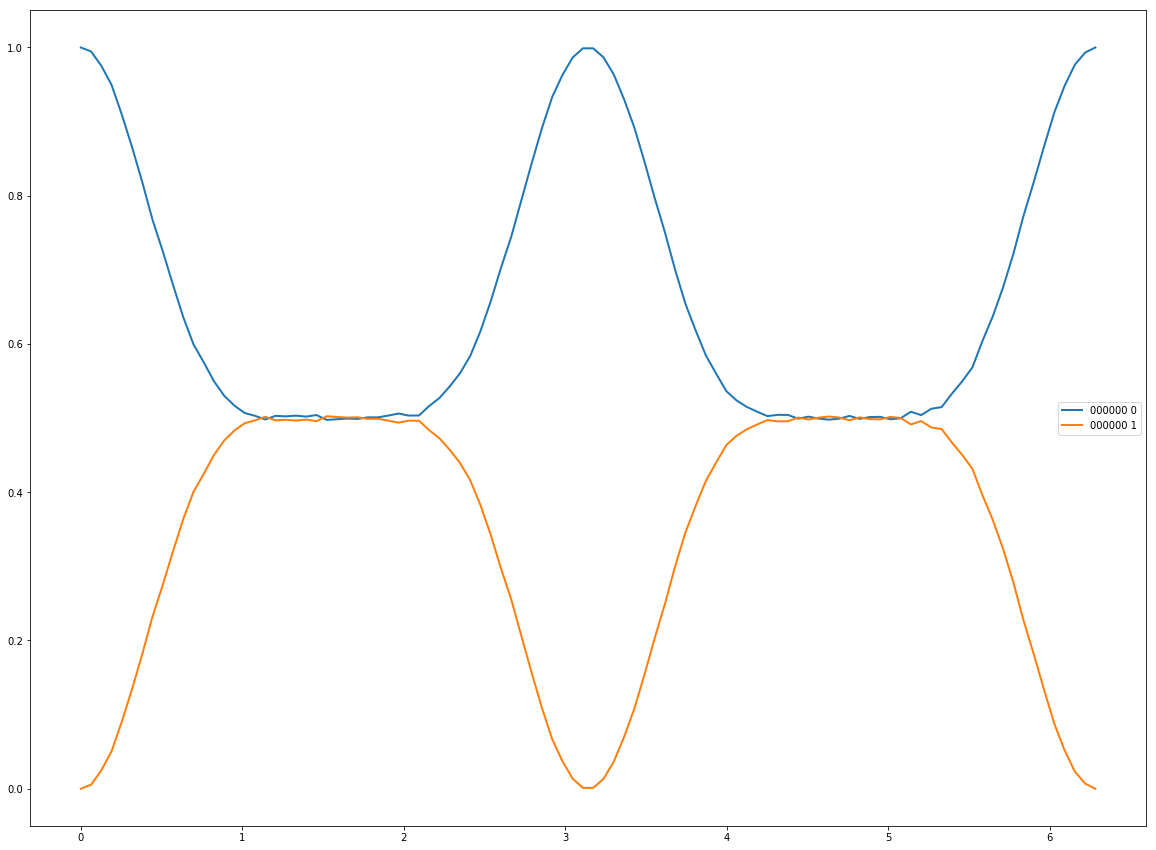

In [16]:
#Equivalent data in lineplot, which hides overlap of crossed states
for c_jj, v_jj in enumerate(uniq_states):
    plt.plot(angles, counts_arr[c_jj][:]/num_samples, linewidth=2, label=v_jj)
plt.legend()

For a 2 qubit (4 float) data set, as the vector is rotated through a variety of angles relative to the reference, we can see occupation of the $|00\rangle$ state (which is $100\%$ at $\Delta\theta=0$), lessens, and states $|01\rangle$ and $|10\rangle$ have non-negligible counts (not shown as requires measurement of the register). As the vector is rotated to $\pi/2$, the occupation of the $|01\rangle$ and $|10\rangle$ drops off, and the $|11\rangle$ state approaches $50\%$, along with $|00\rangle$. This implies that the states are now maximally entangled, in state $\left(|00\rangle + |11\rangle\right)/\sqrt{2}$, with further rotations causing an oscillation through these propbabilities back to the original states.

As such, when the vector as the same, $P(|00\rangle) = 100\%$ $P(\textrm{all others}) = 0\%$, and when they are orthogonal $P(|00\rangle) =50\%$ and $P(|11\rangle)=50\%$.

Measuring the auxiliary bit as implied by PRL 114, 110504 (2015) however does not allow us to extract any information, as measurements of the full state is required.  Applying an additional H gate to the circuit does change this, but leaves us with a large plateau in the region approaching vector orthogonality for larger qubit registers.

In [17]:
for c_jj, v_jj in enumerate(uniq_states):
    for c_ii, v_ii in enumerate(angles):
        cursor.execute('''SELECT counts, state_key, dtheta FROM q_states WHERE dtheta=? AND state_key=?''', (v_ii, v_jj,) )
        all_rows = cursor.fetchall()
        for row in all_rows:
            counts_arr[c_jj][c_ii] = row[0];

# 4 qubit register (upto 16 floating-point values)
If we choose to measure the auxiliary qubit first, we essentially transform the state as follows: for an angle of 0 the auxiliary qubit result is completely separable from the register values as the states are 
$\left(1/\sqrt{2}\right)\left(\vert 0 \rangle + \vert 1 \rangle \right)\vert 0000 \rangle $. When the states are orthogonal, it becomes $\left( \vert 0 \rangle \vert 0000\rangle + \vert 1 \rangle \vert 1111 \rangle \right)(1/\sqrt{2})$ which is maximally entangled.

However, more realistically, we can assume the states of the system can be described as $\left( \vert 0 \rangle \vert \alpha\rangle + \vert 1 \rangle \vert \beta \rangle \right)(c/\sqrt{2})$, where $\alpha, ~\beta$ are the respective arbitrary states to be compared, and $c$ is the normalisation coefficient of the register excluding the auxiliary qubit. Given the above state, performing a Hadamard gate on the resulting auxiliary qubit modifies the overall state to $$\vert \psi \rangle = d\left(\vert 0 \rangle \left( \vert \alpha\rangle + \vert\beta\rangle \right) + \vert 1 \rangle \left( \vert \alpha\rangle - \vert\beta\rangle \right)\right) \\\ = d\left(\vert 0 \rangle + \vert 1 \rangle \frac{\vert \alpha\rangle - \vert\beta\rangle}{ \vert \alpha\rangle + \vert\beta\rangle }\right)
$$. 

In [18]:
num_qubits = 4
for th in np.linspace(0, 2*np.pi, 100, endpoint=True):
    #Prepare the GHZ state on qubits 1,2, and use 0 as the control qubit for Rotations
    q = QuantumRegister(num_qubits); #Entangled state for storing vectors
    a = QuantumRegister(1); #Ancililary qubit for measurements
    c_a = ClassicalRegister(1); #Classical measurement from auxiliary qubit
    c_q = ClassicalRegister(num_qubits); #C measurement on rest of qubit

    ghz_circ = QuantumCircuit(a, q, c_a, c_q);

    ghz_circ.h(a[0]);           

    #Encode the data to test
    x = [1,0]*num_qubits
    y = [np.cos(th),np.sin(th)]*num_qubits
    for ii in range(0,len(x),2):
        ghz_circ.cu3(2*np.arccos(x[ii]), 0, 0, a[0], q[ii//2])
        #ghz_circ.crz(2*np.arccos(x[ii]), a[0], q[ii//2])

    #Next, encode the reference data by flipping the first bit to allow it into the |11> state
    ghz_circ.x(a[0])
    for ii in range(0,len(y),2):
        ghz_circ.cu3(2*np.arccos(y[ii]), 0, 0, a[0], q[ii//2])
        #ghz_circ.crz(2*np.arccos(x[ii]), a[0], q[ii//2])

    #Encode the information into the phase of the auxiliary qubit        
    ghz_circ.h(a[0])

    #Extract result from auxiliary qubit measurement
    m_aux = 1
    m_q = 0
    if m_aux:
        ghz_circ.measure(a, c_a)
        backend = Aer.get_backend('qasm_simulator')
        qobj = compile(ghz_circ, backend, shots=num_samples)
        job = backend.run(qobj)
        result = job.result()
        counts = result.get_counts()
        print(counts)
        for k,v in counts.items():
            cursor.execute('''INSERT INTO q_states(state_key, dtheta, counts, num_qubits, measured_reg) 
                            VALUES(?,?,?,?,?)''', (k, th, v, num_qubits, 'a'))

    if m_q:
        ghz_circ.measure(q, c_q)
        backend = Aer.get_backend('qasm_simulator')
        qobj = compile(ghz_circ, backend, shots=num_samples)
        job = backend.run(qobj)
        result = job.result()
        counts = result.get_counts()
        print(counts)
        for k,v in counts.items():
            cursor.execute('''INSERT INTO q_states(state_key, dtheta, counts, num_qubits, measured_reg) 
                            VALUES(?,?,?,?,?)''', (k, th, v, num_qubits, 'q'))

    conn.commit()

{'0000 0': 30000}
{'0000 1': 134, '0000 0': 29866}
{'0000 1': 481, '0000 0': 29519}
{'0000 1': 1095, '0000 0': 28905}
{'0000 1': 1812, '0000 0': 28188}
{'0000 1': 2793, '0000 0': 27207}
{'0000 1': 3817, '0000 0': 26183}
{'0000 1': 5239, '0000 0': 24761}
{'0000 1': 6263, '0000 0': 23737}
{'0000 1': 7491, '0000 0': 22509}
{'0000 1': 8717, '0000 0': 21283}
{'0000 1': 9907, '0000 0': 20093}
{'0000 1': 10801, '0000 0': 19199}
{'0000 1': 11887, '0000 0': 18113}
{'0000 1': 12627, '0000 0': 17373}
{'0000 1': 13347, '0000 0': 16653}
{'0000 1': 13868, '0000 0': 16132}
{'0000 1': 14272, '0000 0': 15728}
{'0000 1': 14616, '0000 0': 15384}
{'0000 1': 14652, '0000 0': 15348}
{'0000 1': 14945, '0000 0': 15055}
{'0000 1': 14974, '0000 0': 15026}
{'0000 1': 15071, '0000 0': 14929}
{'0000 1': 14934, '0000 0': 15066}
{'0000 1': 15044, '0000 0': 14956}
{'0000 1': 14968, '0000 0': 15032}
{'0000 1': 14974, '0000 0': 15026}
{'0000 1': 14957, '0000 0': 15043}
{'0000 1': 15066, '0000 0': 14934}
{'0000 1': 1496

In [19]:
# Update unique list of states from DB
cursor.execute('''SELECT DISTINCT state_key FROM q_states ''')
uniq_states = [s[0] for s in cursor.fetchall()]

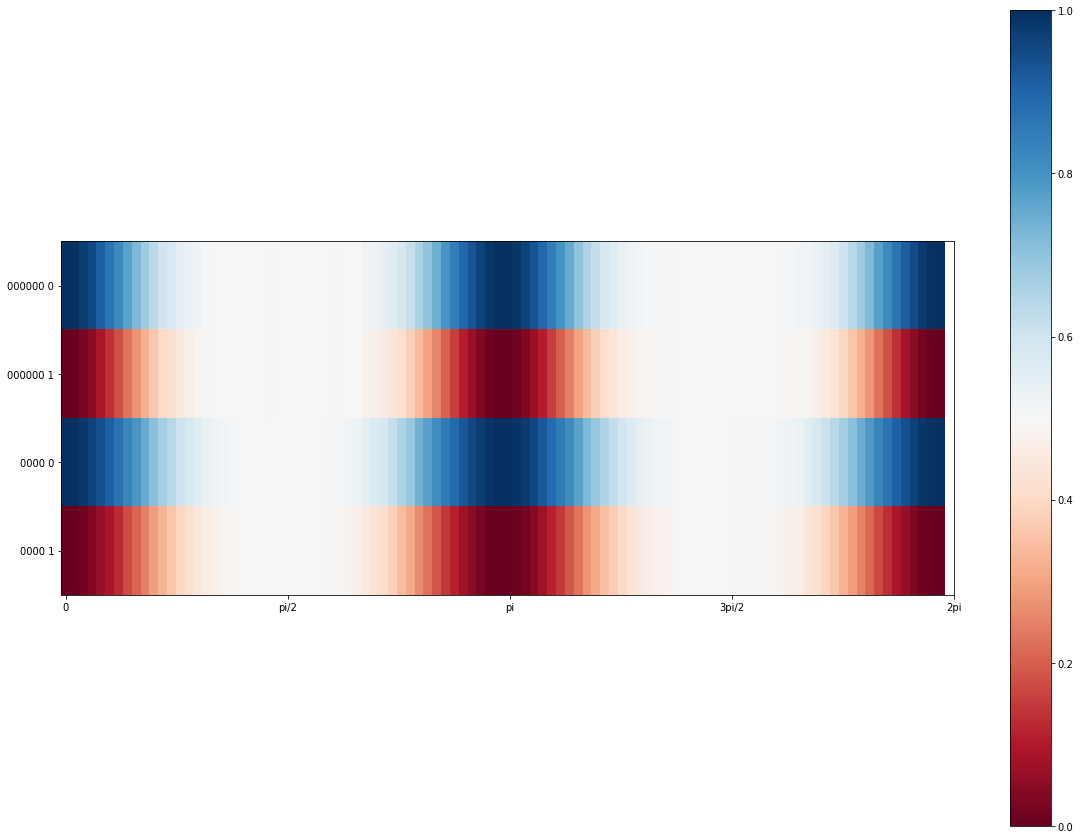

In [20]:
#Extract the appropriate data from the DB and plot the results
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

counts = np.zeros((len(uniq_states), len(angles)));
for c_jj, v_jj in enumerate(uniq_states):
    for c_ii, v_ii in enumerate(angles):
        cursor.execute('''SELECT counts, state_key, dtheta FROM q_states WHERE dtheta=? AND state_key=?''', (v_ii, v_jj,) )
        all_rows = cursor.fetchall()
        for row in all_rows:
            counts[c_jj][c_ii] = row[0];
            
plt.rcParams['figure.figsize'] = [20, 15]
fig, ax = plt.subplots()
im = ax.imshow(counts/num_samples, cmap='RdBu')
ax.set_aspect(10)
plt.xticks([i*16 for i in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]], ['0', 'pi/2', 'pi', '3pi/2', '2pi'])
plt.yticks(np.arange(len(uniq_states)), uniq_states)
cbar = ax.figure.colorbar(im)

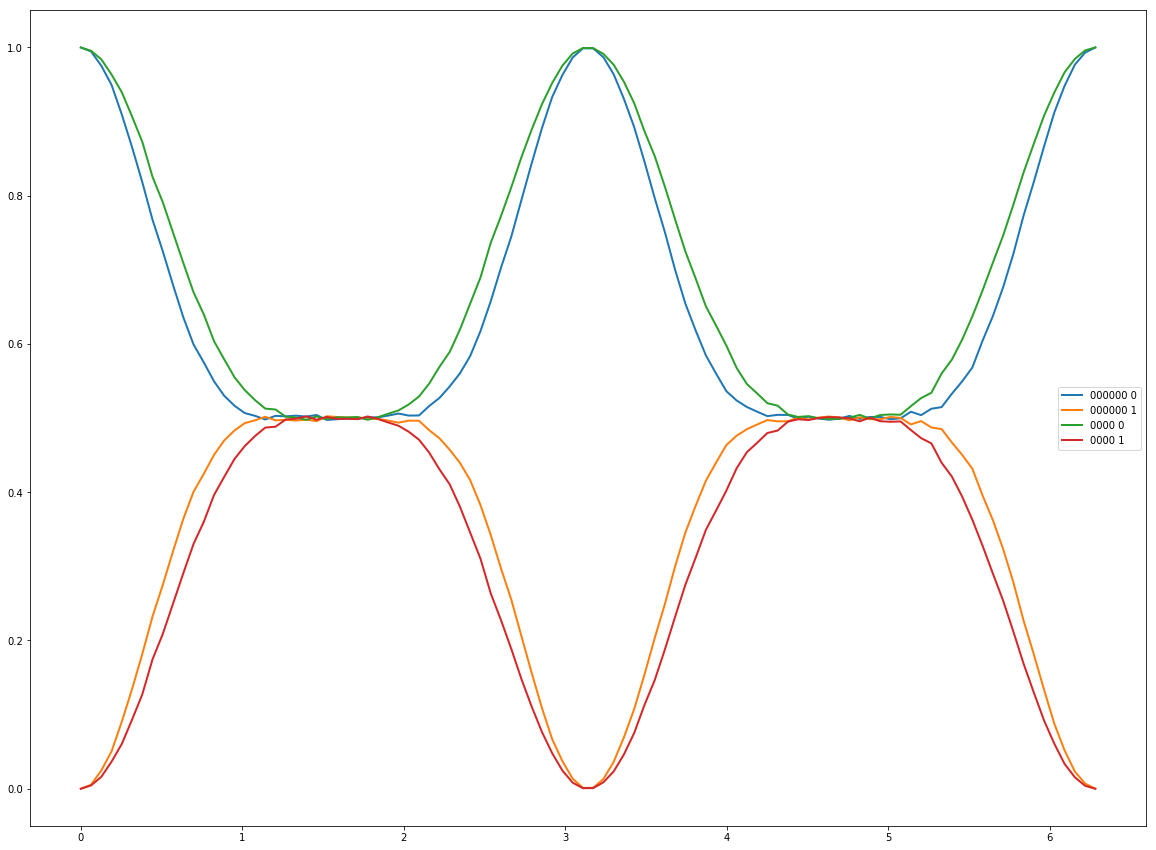

In [21]:
#Equivalent data in lineplot, which hides overlap of crossed states
for c_jj, v_jj in enumerate(uniq_states):
    plt.plot(angles, counts[c_jj][:]/num_samples, linewidth=2)
    plt.legend(uniq_states)

As can be seen, the central region platueaus for increased qubit register size.

In [22]:
qm = ghz_circ.qasm()

In [23]:
print(qm)

OPENQASM 2.0;
include "qelib1.inc";
qreg q402[1];
qreg q401[4];
creg c400[1];
creg c401[4];
h q402[0];
cu3(0.0,0,0) q402[0],q401[0];
cu3(0.0,0,0) q402[0],q401[1];
cu3(0.0,0,0) q402[0],q401[2];
cu3(0.0,0,0) q402[0],q401[3];
x q402[0];
cu3(0.0,0,0) q402[0],q401[0];
cu3(0.0,0,0) q402[0],q401[1];
cu3(0.0,0,0) q402[0],q401[2];
cu3(0.0,0,0) q402[0],q401[3];
h q402[0];
measure q402[0] -> c400[0];

